In [1]:
%load_ext autoreload
%autoreload 2
from database_functions.utils import DB_utils
import pandas as pd
from omegaconf import DictConfig
from transformers import logging as transformers_logging
import logging
import yaml
import hydra
from transformers import AutoModel, AutoTokenizer
import numpy as np
import matplotlib.pyplot as plt
import datetime

/home/maha/projects/stock-price-prediction-with-news-analysis/stockvenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open('./configs/logger/logger_config.yaml', 'r') as file:
    logger_config = yaml.safe_load(file.read())
    logging.config.dictConfig(logger_config)
    logger = logging.getLogger('full_logger')
logger.info('A')

2025-01-04 02:13:55,903 - full_logger - INFO - A


In [3]:
with hydra.initialize(version_base='1.3.2', config_path="configs", job_name="config"):
    cfg = hydra.compose(config_name="config")
cfg

{'db': {'database_connection': {'host': 'localhost', 'port': 5432, 'dbname': 'stock_price_prediction', 'user': 'maha', 'password': 'Alinka2004'}, 'tables_info': {'main_table': 'news_db'}}, 'rbc': {'request_info': {'url': 'https://www.rbc.ru/search/ajax/?', 'query': 'РБК', 'project': 'rbcnews', 'page': 0}, 'other': {'time_step': 1, 'save_to_bd': True}, 'sources': {'Спорт': 'sport', 'Политика': 'politics', 'Общество': 'society', 'Бизнес': 'business', 'Технологии и медиа': 'tecnhologies', 'Экономика': 'economics', 'Финансы': 'finance'}}, 'logger': {'sync_logger_config_path': './configs/logger/logger_config.yaml'}, 'stocks': {'ticket_name': 'LKOH.ME', 'moex_name': 'LKOH', 'training_table': 'lukoil_table'}, 'experiment': {'dateFrom': '2020-01-02', 'dateTo': '2024-08-25', 'model': 'default', 'ticket': 'lukoil', 'news_aggregation_type': 'share'}}

In [7]:
cfg.experiment.dateTo

'2024-08-25'

In [4]:
db_object = DB_utils(cfg=cfg, logger=logger)
db_object.connect(connect_to_postgres=False)

2025-01-04 02:13:56,262 - full_logger - DEBUG - Connecting to stock_price_prediction database


In [9]:
df = db_object.get_training_dataset()
df = pd.DataFrame(df, columns=['report_date', 'news', 'delta'])

2025-01-03 18:32:20,672 - full_logger - DEBUG - Training data was fetched, 0 rows


In [8]:
df.head()

report_date                                               news        delta
0  2020-01-02  «Булгаргаз» продолжает переговоры с «Газпром э...         0E-8
1  2020-01-03  По его мнению, то, что Тартуский договор нахо...  -1.45885387
2  2020-01-06  О том, что Россия остановила поставки нефти в ...  -1.30158730
3  2020-01-08  «Смерть Сулеймани — это тяжелый удар по иран...  -1.50781250
4  2020-01-09  Президент России выразил признательность власт...   0.31007752

In [15]:
model_name = "./transformers_base/DeepPavlov-rubert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name, clean_up_tokenization_spaces=True)
df['token_lengths'] = df['news'].apply(
    lambda x: len(tokenizer.tokenize(x))
)

In [17]:
!mkdir data

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [18]:
df.to_csv('./data/tmp.csv', index=False)

<Axes: >

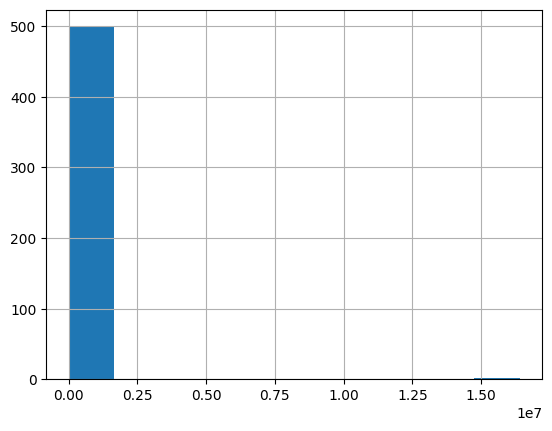

In [19]:
df['token_lengths'].hist()

In [28]:
df.news[0]

'«Булгаргаз» продолжает переговоры с «Газпром экспортом» о снижении цены поставок газа, говорится в сообщении компании. Болгарская сторона настаивает на том, чтобы цена для болгарского потребителя отражала развитие газовых хабов на континенте и текущие пограничные цены для Германии, Франции и Италии. Заинтересованность обеих сторон подразумевает, что переговоры должны быть завершены как можно скорее в начале 2020 года. Источник в «Газпроме» подтвердил РБК, что болгары начали закупать газ по «Турецкому потоку». «Торжественный запуск «Турецкого потока» 8 января — это символический жест, газ должен был пойти по этому газопроводу с 1 января 2020 года», — добавил он. «Квалифицированно ответить, получает ли Болгария газ с турецкого направления (по «Турецкому потоку». — РБК), можно будет завтра, когда «Булгаргаз» «закроет сутки» 1 января», — сказал РБК пресс-секретарь главы «Газпрома» Сергей Куприянов. Глава «Булгаргаза» Николай Павлов ранее заявил, что причины переноса точки приема газа

In [6]:
db_object = DB_utils(cfg=cfg, logger=logger)
db_object.connect(connect_to_postgres=False)
db_object.drop_table(table_name=cfg.stocks.training_table)
db_object.check_or_create_training_table()
existed_dates = db_object.get_min_max_dates_from_main_table()

2025-01-04 02:14:18,570 - full_logger - DEBUG - Connecting to stock_price_prediction database


2025-01-04 02:14:18,639 - full_logger - INFO - Table lukoil_table was dropped
2025-01-04 02:14:18,695 - full_logger - INFO - Created table lukoil_table


In [7]:
from other.utils import adjust_dates, assign_date_group, get_unique_date_intervals, group_weekends

cfg = adjust_dates(
    existed_dates=existed_dates, 
    cfg=cfg.copy(), 
    logger=logger
)

In [8]:
existed_training_dates = db_object.get_min_max_dates_from_stocks_table()
unique_date_intervals = []
if len(existed_training_dates) == 0:
    unique_date_intervals.append([cfg.experiment.dateFrom, cfg.experiment.dateTo])
else:
    print("A")
    unique_date_intervals = get_unique_date_intervals(
        new_date_left=cfg.experiment.dateFrom,
        new_date_right=cfg.experiment.dateTo,
        existed_date_left=existed_training_dates[0],
        existed_date_right=existed_training_dates[1]
    )


2025-01-04 02:14:24,055 - full_logger - DEBUG - Table lukoil_table was empty


In [9]:
def classify_value(x):
    if x > 0.5:
        return 1
    elif x < -0.5:
        return 2
    else:
        return 0

In [11]:
from parsers.moex_parser import MoexParser
left_border, right_border = unique_date_intervals[0][0], unique_date_intervals[0][1]
cfg.experiment.dateFrom = left_border
cfg.experiment.dateTo = right_border
moex_object = MoexParser(
    cfg=cfg, 
    logger=logger
)
prices = moex_object.parse_data()
result = db_object.get_news_within_timeframe(
    start_date=cfg.experiment.dateFrom,
    end_date=cfg.experiment.dateTo
)
result = pd.DataFrame(result, columns=["publish_date", "news"])
result["group_date"] = result["publish_date"].apply(assign_date_group)
result = pd.merge(
    left=result,
    right=prices,
    how="inner",
    left_on="group_date",
    right_on="report_date"
)
result = result.drop(columns=["publish_date"])
result = group_weekends(
    df=result, 
    news_aggregation_type=cfg.experiment.news_aggregation_type
)
# print(result.head())
db_object.insert_into_training_table(data=result)

2025-01-04 02:15:12,384 - full_logger - INFO - Parsing prices from 2020-01-02 till 2024-08-25


2025-01-04 02:15:35,170 - full_logger - INFO - Parsing prices was finished
2025-01-04 02:15:38,198 - full_logger - DEBUG - 103850 news were fetched
2025-01-04 02:16:01,444 - full_logger - INFO - 103850 rows were inserted into table lukoil_table


In [15]:
result_new = result[result["price_change"] != 0].reset_index(drop=True)
a = result_new['price_change'].apply(classify_value)

(a==0).sum() / result_new.shape[0], (a==1).sum() / result_new.shape[0], (a==2).sum() / result_new.shape[0], 

(0.25582534843205573, 0.37723214285714285, 0.3669425087108014)

In [ ]:
# result = group_weekends(result)

print(result.shape)
a = result.price_change.apply(classify_value)
print((a == 1).sum() / result.shape[0], (a == 2).sum() / result.shape[0], (a == 0).sum() / result.shape[0])

In [47]:
from parsers.moex_parser import MoexParser
left_border, right_border = unique_date_intervals[0][0], unique_date_intervals[0][1]
cfg.experiment.dateFrom = left_border
cfg.experiment.dateTo = right_border
moex_object = MoexParser(
    cfg=cfg, 
    logger=logger
)
prices = moex_object.parse_data()
result = db_object.get_news_within_timeframe(
    start_date=cfg.experiment.dateFrom,
    end_date=cfg.experiment.dateTo
)
result = pd.DataFrame(result, columns=["publish_date", "news"])
result["group_date"] = result["publish_date"].apply(assign_date_group)
result = result\
    .groupby("group_date")\
        .agg({"news": " ".join})\
            .reset_index()\
                .rename(columns={"group_date": "publish_date"})
result = pd.merge(
    left=result,
    right=prices,
    how="inner",
    left_on="publish_date",
    right_on="report_date"
)
result = result.drop(columns=["publish_date"])
result = group_weekends(result)
print(result.shape)
a = result.price_change.apply(classify_value)
print((a == 1).sum() / result.shape[0], (a == 2).sum() / result.shape[0], (a == 0).sum() / result.shape[0])

2025-01-03 18:47:33,916 - full_logger - INFO - Parsing prices from 2020-01-02 till 2024-08-25


2025-01-03 18:47:34,578 - full_logger - INFO - Parsing prices was finished
2025-01-03 18:47:37,293 - full_logger - DEBUG - 103850 news were fetched
(500, 3)
0.36 0.358 0.282


In [110]:
model_name = "./transformers_base/DeepPavlov-rubert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name, clean_up_tokenization_spaces=True)
token_lengths = df['news'].apply(lambda x: len(tokenizer.encode(x, add_special_tokens=True)))

: 

In [ ]:
df.shape

In [ ]:
import numpy as np
mean_length = token_lengths.mean()
median_length = token_lengths.median()
max_length = token_lengths.max()
percentile_95_length = np.percentile(token_lengths, 95)

In [62]:
db_object.check_or_create_db()

2025-01-02 02:18:34,065 - full_logger - INFO - Database stock_price_prediction already exists


In [97]:
db_object.connect(connect_to_postgres=False)
query = """
SELECT COUNT(*)
FROM sber_table
"""

db_object._cursor.execute(query)
res = db_object._cursor.fetchall()
res

2025-01-02 17:52:25,199 - full_logger - DEBUG - Connecting to stock_price_prediction database


[(501,)]

In [68]:
cfg.experiment.ticket

'sber'

In [98]:
db_object.get_min_max_dates_from_stocks_table()

(datetime.date(2020, 1, 9), datetime.date(2024, 8, 15))